In [42]:
import json
from operator import itemgetter
from pathlib import Path

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pyLDAvis
import pyLDAvis.gensim_models
import seaborn as sns
from gensim.corpora import Dictionary as CorporaDictionary
from gensim.models import CoherenceModel
from gensim.models.ldamodel import LdaModel
from nltk.corpus import stopwords
from nltk.stem import SnowballStemmer, WordNetLemmatizer
from nltk.tokenize import RegexpTokenizer
from numpyencoder import NumpyEncoder
from sklearn.feature_extraction.text import TfidfVectorizer
from wordcloud import WordCloud
%matplotlib inline

In [2]:
# create list of strings, each string representing one article
# there are a variable number of articles per file
corpus = []
for txt in sorted(Path('Articles').iterdir()):
    with open(txt) as f:
        # split article on \f (feed file character)
        documents = "\n".join(f.readlines()).split("\f")
        corpus.extend(documents)

# there are 1622 articles in the corpus
len(corpus)

1622

In [3]:
# skip metadata at beginning and end of every document
def remove_metadata(document: str) -> str:
    lines = [line for l in document.split("\n") if (line := l.strip())]
    for i, line in enumerate(lines):
        lower_line = line.lower()
        # slice article after copyright (usually lines 10-11)
        if lower_line.startswith("copyright") or lower_line.startswith("©"):
            # slice article before the document ID (last line)
            return "\n".join(lines[i + 1: -1])

In [4]:

TOKENIZER = RegexpTokenizer(r"\w+")  # splits on any non-word character
LEMMATIZER = WordNetLemmatizer()
# STEMMER = SnowballStemmer('english')

# removing the lemmas "say" and "mr" because a lot of these articles are from the NYT and they use those a lot
STOPWORDS = set(stopwords.words('english')) | {"say", "mr"}

def preprocess_text(text: str) -> str:
    
    # remove metadata using above function
    meta_stripped = remove_metadata(text)
    
    # tokenize, remove punctuation
    tokens: list[str] = TOKENIZER.tokenize(meta_stripped)

    # lowercase all, lemmatize verbs
    lemmas = [LEMMATIZER.lemmatize(token.lower(), pos="v") for token in tokens]
    
    # # stem tokens
    # stems = [STEMMER.stem(l) for l in lemmas]

    # remove stopwords, numbers, and non-english words
    keywords = [w for w in lemmas if all((w not in STOPWORDS, w.isascii(), w.isalpha()))]
    
    return " ".join(keywords)

In [5]:
# create list of preprocessed strings, each string is an article (document)
processed_corpus = [preprocess_text(document) for document in corpus]

In [6]:
# extract features using TF-IDF and store in pandas dataframe
vectorizer = TfidfVectorizer()
X = vectorizer.fit_transform(processed_corpus).toarray()
tokens = vectorizer.get_feature_names_out()
df = pd.DataFrame(data=X, columns=tokens)

In [7]:
# correct n_documents (1622), 32752 extracted features
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1622 entries, 0 to 1621
Columns: 32752 entries, aa to zyed
dtypes: float64(32752)
memory usage: 405.3 MB


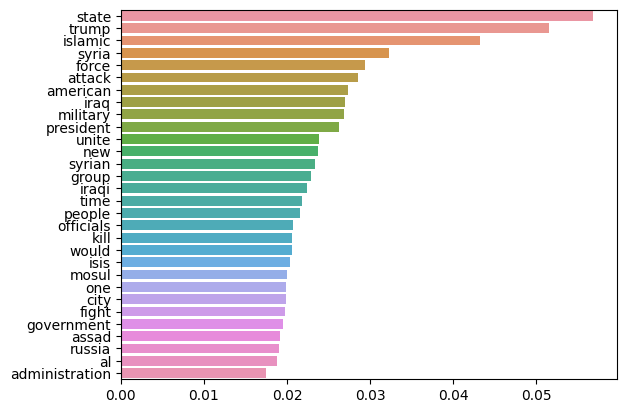

In [8]:
# bar plot of top 30 words
top_30 = df.mean().sort_values(ascending=False)[:30]
sns.barplot(y=top_30.index, x=top_30)
plt.show()

/Users/bsu/code/miniproject3-group5/.venv/lib/python3.11/site-packages/wordcloud/wordcloud.py:106: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  self.colormap = plt.cm.get_cmap(colormap)


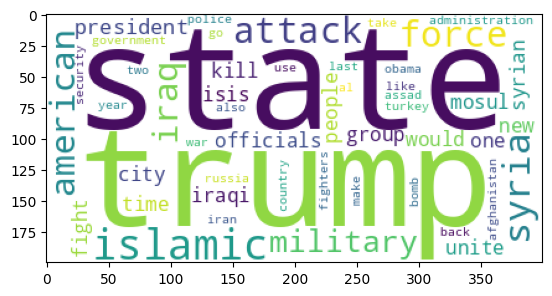

In [43]:
# word cloud of top 50 words
wordcloud = WordCloud(background_color="white", max_words=50).generate_from_frequencies(df.T.sum(axis=1))
plt.imshow(wordcloud)
plt.show()

In [10]:
# prep docs into list of tokens for gensim 
texts = [document.split() for document in processed_corpus]
id2word = CorporaDictionary(texts)
bows = [id2word.doc2bow(text) for text in texts]

In [31]:
# slick formatter to clean up disgusting LdaModel.show_topics() output
def format_topics(output):
    return {
        int(topic_num): {
            k: float(v)
            for v, k in [
                x_item.split("*") for x_item in x.replace('"', "").split(" + ")
            ]
        }
        for topic_num, x in output
    }

In [34]:
lda_scores = Path("lda_scores/")
lda_scores.mkdir(parents=False, exist_ok=True)

model_results = []

# grid search for best LDA hyperparameters
# n_topics range 2-10
# alpha 0.01, .3, 1
# beta 0.01, .3, 1
for n_topics in range(2, 11):
    for a in (0.01, 0.3, 1):
        for b in (0.01, 0.3, 1):
            n_model = LdaModel(corpus=bows,
                id2word=id2word,
                random_state=42,
                update_every=1,
                passes=10,
                per_word_topics=True,
                num_topics=n_topics,
                alpha=a,
                eta=b
            )

            coherence_model = CoherenceModel(model=n_model, texts=texts, dictionary=id2word)

            output = {
                'n_topics': n_topics,
                'alpha': a,
                'eta': b,
                'perplexity': n_model.log_perplexity(bows),
                'coherence': coherence_model.get_coherence(),
                'topics': format_topics(n_model.show_topics())
            }

            model_results.append(output)

            with open(lda_scores / f"{n_topics=}_{a=}_{b=}.json", "w") as f:
                json.dump(output, f, ensure_ascii=False, indent=2, cls=NumpyEncoder)

with open(lda_scores / f"grid_search.json", "w") as f:
    json.dump(model_results, f, ensure_ascii=False, indent=2, cls=NumpyEncoder)


Traceback (most recent call last):
  File "<string>", line 1, in <module>
  File "/opt/homebrew/Cellar/python@3.11/3.11.3/Frameworks/Python.framework/Versions/3.11/lib/python3.11/multiprocessing/spawn.py", line 120, in spawn_main
    exitcode = _main(fd, parent_sentinel)
               ^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/opt/homebrew/Cellar/python@3.11/3.11.3/Frameworks/Python.framework/Versions/3.11/lib/python3.11/multiprocessing/spawn.py", line 130, in _main
    self = reduction.pickle.load(from_parent)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
_pickle.UnpicklingError: pickle data was truncated


In [39]:
# sort grid search to find minimum perplexity
best_perplexity = sorted(model_results, key=itemgetter('perplexity'))[0]
newlist = print(json.dumps(best_perplexity, indent=4))
min_perplexity = LdaModel(corpus=bows,
    id2word=id2word,
    random_state=42,
    update_every=1,
    passes=10,
    per_word_topics=True,
    num_topics=best_perplexity["n_topics"],
    alpha=best_perplexity["alpha"],
    eta=best_perplexity["eta"],
)

{
    "n_topics": 10,
    "alpha": 1,
    "eta": 0.01,
    "perplexity": -8.742817968596645,
    "coherence": 0.4151098774566135,
    "topics": {
        "0": {
            "state": 0.024,
            "islamic": 0.021,
            "force": 0.012,
            "syria": 0.009,
            "group": 0.008,
            "city": 0.008,
            "iraq": 0.008,
            "al": 0.007,
            "military": 0.007,
            "fighters": 0.007
        },
        "1": {
            "u": 0.016,
            "syria": 0.015,
            "state": 0.013,
            "turkey": 0.012,
            "syrian": 0.01,
            "russia": 0.01,
            "kurdish": 0.009,
            "assad": 0.009,
            "trump": 0.008,
            "russian": 0.008
        },
        "2": {
            "time": 0.006,
            "facebook": 0.006,
            "new": 0.005,
            "people": 0.005,
            "news": 0.005,
            "like": 0.005,
            "one": 0.005,
            "make": 0.004,
     

In [41]:
# topic modeling visualization for minimum perplexity
# n_topics=10, alpha=1, beta=0.01
pyLDAvis.enable_notebook()
vis = pyLDAvis.gensim_models.prepare(min_perplexity, bows, id2word)
vis

PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
5      0.084222 -0.109132       1        1  16.860276
0     -0.091764  0.086174       2        1  15.774126
6     -0.077852 -0.078536       3        1  13.863574
2      0.112776 -0.059118       4        1   9.759226
4      0.014357 -0.008386       5        1   9.321374
9      0.089893  0.079920       6        1   8.126201
1     -0.153363 -0.046467       7        1   7.381453
8      0.101739  0.051184       8        1   6.796420
3     -0.026265  0.101464       9        1   6.148082
7     -0.053744 -0.017103      10        1   5.969268, topic_info=            Term          Freq         Total Category  logprob  loglift
413        state  10714.000000  10714.000000  Default  30.0000  30.0000
220      islamic   6209.000000   6209.000000  Default  29.0000  29.0000
457        trump   7583.000000   7583.000000  Default  28.0000  28.0000
44        attack   3978.000000   3978.000000  Default  27.0000  27.0000
437        syria   4057.000000   4057.000000  Default  26.0000  26.0000
...          ...           ...           ...      ...      ...      ...
1156       would    250.398764   4028.024023  Topic10  -5.5021   0.0406
26      american    234.364208   3993.668374  Topic10  -5.5683  -0.0170
193   government    226.639171   2789.204280  Topic10  -5.6018   0.3084
285          new    230.438116   4214.805417  Topic10  -5.5852  -0.0878
437        syria    203.515641   4057.711488  Topic10  -5.7094  -0.1741

[966 rows x 6 columns], token_table=       Topic      Freq        Term
term                              
8833       8  0.946523       aalla
19788      4  0.937474     abballa
19788      9  0.039061     abballa
29591      4  0.970289   abdeslams
20294      9  1.017867        abdi
...      ...       ...         ...
2511       2  0.990536        zour
24461      4  0.970389        zuck
4007       1  0.006929  zuckerberg
4007       4  0.983957  zuckerberg
4007       8  0.006929  zuckerberg

[3463 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[6, 1, 7, 3, 5, 10, 2, 9, 4, 8])

In [35]:
# sort grid search to find highest coherence
best_coherence = sorted(model_results, key=itemgetter('coherence'), reverse=True)[0]
newlist = print(json.dumps(best_coherence, indent=4))
max_coherence = LdaModel(corpus=bows,
    id2word=id2word,
    random_state=42,
    update_every=1,
    passes=10,
    per_word_topics=True,
    num_topics=best_coherence["n_topics"],
    alpha=best_coherence["alpha"],
    eta=best_coherence["eta"],
)

{
    "n_topics": 5,
    "alpha": 1,
    "eta": 1,
    "perplexity": -8.244830254209925,
    "coherence": 0.45879086815839776,
    "topics": {
        "0": {
            "state": 0.017,
            "islamic": 0.014,
            "syria": 0.009,
            "force": 0.009,
            "u": 0.007,
            "military": 0.007,
            "group": 0.006,
            "iraq": 0.006,
            "american": 0.006,
            "syrian": 0.006
        },
        "1": {
            "shall": 0.002,
            "state": 0.002,
            "order": 0.002,
            "unite": 0.002,
            "entry": 0.002,
            "section": 0.002,
            "secretary": 0.002,
            "nationals": 0.001,
            "effective": 0.001,
            "visa": 0.001
        },
        "2": {
            "time": 0.006,
            "new": 0.005,
            "one": 0.005,
            "like": 0.005,
            "people": 0.004,
            "make": 0.003,
            "would": 0.003,
            "go": 0.003,


In [38]:
# topic modeling visualization for max coherence
# n_topics=5, alpha=1, beta=1
pyLDAvis.enable_notebook()
vis = pyLDAvis.gensim_models.prepare(max_coherence, bows, id2word)
vis

PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
0     -0.103563 -0.071555       1        1  31.814195
4     -0.057430  0.008694       2        1  29.997876
2      0.007101  0.068115       3        1  22.188867
3     -0.025902  0.031359       4        1  15.340707
1      0.179793 -0.036613       5        1   0.658355, topic_info=              Term         Freq        Total Category  logprob  loglift
457          trump  6664.000000  6664.000000  Default  30.0000  30.0000
413          state  9666.000000  9666.000000  Default  29.0000  29.0000
220        islamic  5753.000000  5753.000000  Default  28.0000  28.0000
437          syria  3647.000000  3647.000000  Default  27.0000  27.0000
29687        gigot   873.000000   873.000000  Default  26.0000  26.0000
...            ...          ...          ...      ...      ...      ...
455         travel     4.051263   622.341386   Topic5  -7.4215  -0.0113
767    information     3.939081   621.257015   Topic5  -7.4496  -0.0376
447      terrorist     4.025032  1003.970997   Topic5  -7.4280  -0.4960
1229             c     3.854961   443.751368   Topic5  -7.4712   0.2773
209          image     3.778930   653.446255   Topic5  -7.4911  -0.1296

[417 rows x 6 columns], token_table=       Topic      Freq        Term
term                              
7755       1  0.011315     abraham
7755       2  0.022630     abraham
7755       3  0.927831     abraham
7755       4  0.033945     abraham
16781      1  0.031359    ackerman
...      ...       ...         ...
2511       4  0.011184        zour
4007       1  0.007707  zuckerberg
4007       2  0.007707  zuckerberg
4007       3  0.971103  zuckerberg
4007       4  0.015414  zuckerberg

[1478 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[1, 5, 3, 4, 2])